# Ingeniería de Características - Proyecto de Severidad de Siniestros

**Objetivo**: Transformar y preparar los datos para el modelado predictivo.

**Tareas**:
1. División de datos (train/test)
2. Pipeline de preprocesamiento
3. Transformaciones específicas para seguros
4. Guardar preprocesadores para producción

In [4]:
# Celda 1: Importaciones y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import os

# Celda 1.5: Añadir la ruta del proyecto a sys.path
import sys
from pathlib import Path

# Obtener la ruta absoluta del directorio padre (la raíz del proyecto)
project_root = Path().resolve().parent
# Añadirlo al path de Python
sys.path.append(str(project_root))

# Ahora deberían funcionar las importaciones
from src.data.make_dataset import generate_sample_data
from src.features.build_features import create_feature_pipeline

print(f"✅ Ruta del proyecto añadida: {project_root}")

# Importar nuestros módulos
from src.data.make_dataset import generate_sample_data
from src.features.build_features import create_feature_pipeline

# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2

print("✅ Configuración completada")

✅ Ruta del proyecto añadida: /home/mz8k/mlops-severidad-siniestros-actuariales
✅ Configuración completada


In [5]:
# Cargar y preparar datos
print("📊 Cargando dataset...")
df = generate_sample_data()

# Crear variables derivadas (ingeniería de características específica para seguros)
print("🔧 Creando variables derivadas...")

# 1. Edad agrupada (rangos actuariales típicos)
df['edad_grupo'] = pd.cut(df['edad'], 
                         bins=[18, 25, 35, 45, 55, 65, 70],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-70'])

# 2. Antigüedad agrupada
df['antiguedad_grupo'] = pd.cut(df['antiguedad_vehiculo'],
                               bins=[0, 3, 7, 15, 20],
                               labels=['0-3', '4-7', '8-15', '16-20'])

# 3. Variable binaria: conductor de alto riesgo
df['alto_riesgo'] = ((df['edad'] < 25) | (df['edad'] > 65) | 
                    (df['historial_siniestros'] >= 3)).astype(int)

print("✅ Variables derivadas creadas")
print(f"📐 Nuevas dimensiones: {df.shape}")
print(f"📋 Nuevas columnas: {list(df.columns)}")


📊 Cargando dataset...
🔧 Creando variables derivadas...
✅ Variables derivadas creadas
📐 Nuevas dimensiones: (1000, 9)
📋 Nuevas columnas: ['edad', 'tipo_vehiculo', 'antiguedad_vehiculo', 'region', 'historial_siniestros', 'costo_siniestro', 'edad_grupo', 'antiguedad_grupo', 'alto_riesgo']


In [6]:
# División estratégica de datos (importante para seguros)
print("🎯 División de datos en entrenamiento y prueba...")

# Variable objetivo (transformación logarítmica común en seguros)
y = np.log1p(df['costo_siniestro'])  # log(1 + x) para manejar ceros

# Variables predictoras (excluir la variable objetivo original)
X = df.drop('costo_siniestro', axis=1)

# División estratificada por región (para mantener distribución geográfica)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=X['region']  # Estratificar por región
)

print("✅ Datos divididos correctamente")
print(f"📊 Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"📊 Conjunto de prueba: {X_test.shape[0]} muestras")
print(f"🎯 Variable objetivo transformada (logarítmica)")


🎯 División de datos en entrenamiento y prueba...
✅ Datos divididos correctamente
📊 Conjunto de entrenamiento: 800 muestras
📊 Conjunto de prueba: 200 muestras
🎯 Variable objetivo transformada (logarítmica)


🔍 Verificando distribución en train/test...


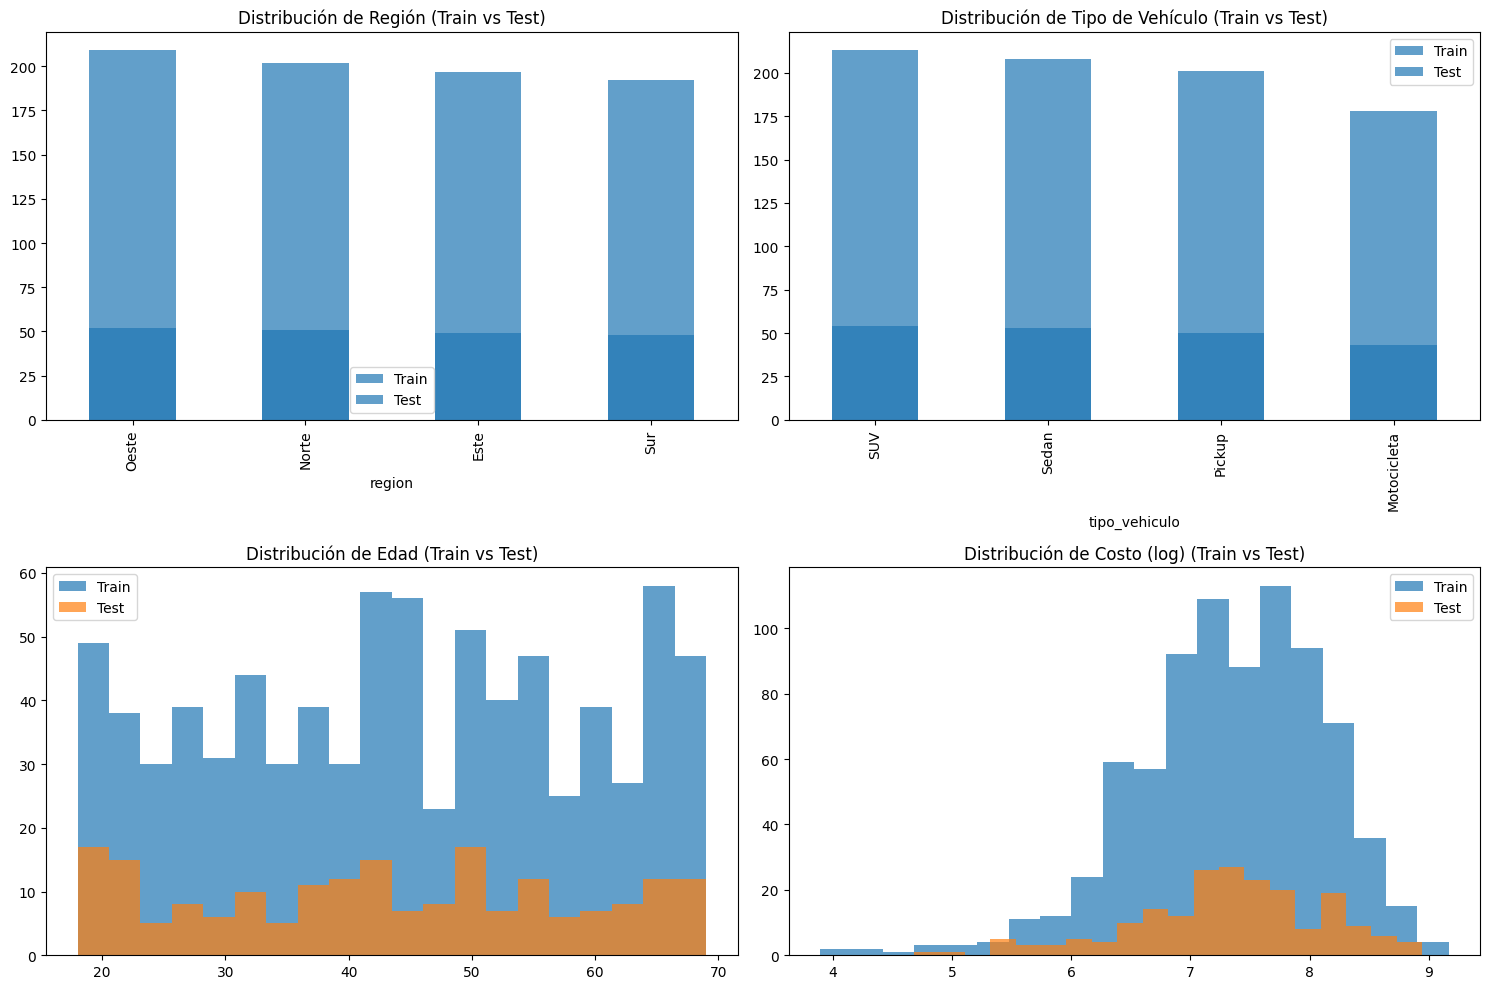

📈 Estadísticas de la variable objetivo:
Train - Media: 7.3373, Std: 0.7807
Test  - Media: 7.3254, Std: 0.7917


In [7]:
# : Análisis de la división
print("🔍 Verificando distribución en train/test...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de región
X_train['region'].value_counts().plot(kind='bar', ax=axes[0,0], alpha=0.7, label='Train')
X_test['region'].value_counts().plot(kind='bar', ax=axes[0,0], alpha=0.7, label='Test')
axes[0,0].set_title('Distribución de Región (Train vs Test)')
axes[0,0].legend()

# Distribución de tipo de vehículo
X_train['tipo_vehiculo'].value_counts().plot(kind='bar', ax=axes[0,1], alpha=0.7, label='Train')
X_test['tipo_vehiculo'].value_counts().plot(kind='bar', ax=axes[0,1], alpha=0.7, label='Test')
axes[0,1].set_title('Distribución de Tipo de Vehículo (Train vs Test)')
axes[0,1].legend()

# Distribución de edad
axes[1,0].hist(X_train['edad'], alpha=0.7, label='Train', bins=20)
axes[1,0].hist(X_test['edad'], alpha=0.7, label='Test', bins=20)
axes[1,0].set_title('Distribución de Edad (Train vs Test)')
axes[1,0].legend()

# Distribución de variable objetivo
axes[1,1].hist(y_train, alpha=0.7, label='Train', bins=20)
axes[1,1].hist(y_test, alpha=0.7, label='Test', bins=20)
axes[1,1].set_title('Distribución de Costo (log) (Train vs Test)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Verificación estadística
print("📈 Estadísticas de la variable objetivo:")
print(f"Train - Media: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Test  - Media: {y_test.mean():.4f}, Std: {y_test.std():.4f}")

In [8]:
# Definir pipelines de preprocesamiento
print("🔧 Configurando pipelines de preprocesamiento...")

# Columnas originales
numeric_features = ['edad', 'antiguedad_vehiculo', 'historial_siniestros']
categorical_features = ['tipo_vehiculo', 'region']

# Columnas derivadas
categorical_derived = ['edad_grupo', 'antiguedad_grupo']
binary_features = ['alto_riesgo']

# Pipeline para características numéricas originales
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para características categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline para características binarias (no necesitan transformación)
from sklearn.preprocessing import FunctionTransformer
binary_transformer = FunctionTransformer(lambda x: x)  # Transformación identidad

# Preprocesador completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cat_derived', categorical_transformer, categorical_derived),
        ('binary', binary_transformer, binary_features)
    ])

print("✅ Pipeline de preprocesamiento creado")
print(preprocessor)

🔧 Configurando pipelines de preprocesamiento...
✅ Pipeline de preprocesamiento creado
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['edad', 'antiguedad_vehiculo',
                                  'historial_siniestros']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['tipo_vehiculo', 'region']),
                                ('cat_derived',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                               

In [9]:
# Ajustar y transformar los datos
print("🔄 Ajustando pipeline a datos de entrenamiento...")

# Ajustar el preprocesador con los datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("✅ Transformación completada")
print(f"📐 Train procesado: {X_train_processed.shape}")
print(f"📐 Test procesado: {X_test_processed.shape}")

# Obtener nombres de características
feature_names = numeric_features + binary_features

# Añadir nombres de características categóricas
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
if hasattr(cat_encoder, 'get_feature_names_out'):
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_features)
    
    # Características derivadas categóricas
    cat_derived_encoder = preprocessor.named_transformers_['cat_derived'].named_steps['onehot']
    cat_derived_features = cat_derived_encoder.get_feature_names_out(categorical_derived)
    feature_names.extend(cat_derived_features)

print(f"📋 Total de características: {len(feature_names)}")

🔄 Ajustando pipeline a datos de entrenamiento...
✅ Transformación completada
📐 Train procesado: (800, 20)
📐 Test procesado: (200, 20)
📋 Total de características: 20


In [11]:
# Celda 7: Ajustar y transformar los datos (VERSIÓN CORREGIDA)
print("🔄 Ajustando pipeline a datos de entrenamiento...")

# Ajustar el preprocesador con los datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Añadir características binarias manualmente (no necesitan transformación)
binary_features_train = X_train[['alto_riesgo']].values
binary_features_test = X_test[['alto_riesgo']].values

# Combinar características procesadas con binarias
X_train_processed = np.hstack([X_train_processed, binary_features_train])
X_test_processed = np.hstack([X_test_processed, binary_features_test])

print("✅ Transformación completada")
print(f"📐 Train procesado: {X_train_processed.shape}")
print(f"📐 Test procesado: {X_test_processed.shape}")

# Obtener nombres de características
feature_names = numeric_features.copy()

# Añadir nombres de características categóricas
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
if hasattr(cat_encoder, 'get_feature_names_out'):
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_features)
    
    # Características derivadas categóricas
    cat_derived_encoder = preprocessor.named_transformers_['cat_derived'].named_steps['onehot']
    cat_derived_features = cat_derived_encoder.get_feature_names_out(categorical_derived)
    feature_names.extend(cat_derived_features)

# Añadir características binarias al final
feature_names.extend(['alto_riesgo'])

print(f"📋 Total de características: {len(feature_names)}")

🔄 Ajustando pipeline a datos de entrenamiento...
✅ Transformación completada
📐 Train procesado: (800, 21)
📐 Test procesado: (200, 21)
📋 Total de características: 20


In [12]:
# Celda 7.5: Verificar que el preprocesador es serializable
print("🔍 Verificando serialización del preprocesador...")

try:
    # Probar serialización en memoria primero
    import io
    buffer = io.BytesIO()
    joblib.dump(preprocessor, buffer)
    buffer.seek(0)
    preprocessor_loaded = joblib.load(buffer)
    print("✅ Preprocesador serializable correctamente")
except Exception as e:
    print(f"❌ Error en serialización: {e}")
    print("🔄 Usando solución alternativa...")
    
    # Solución alternativa: crear un preprocesador simplificado
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    
    preprocessor_simple = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
             categorical_features + categorical_derived)
        ])
    
    # Re-entrenar con el preprocesador simplificado
    X_train_processed = preprocessor_simple.fit_transform(X_train)
    X_test_processed = preprocessor_simple.transform(X_test)
    
    # Añadir características binarias
    X_train_processed = np.hstack([X_train_processed, X_train[['alto_riesgo']].values])
    X_test_processed = np.hstack([X_test_processed, X_test[['alto_riesgo']].values])
    
    preprocessor = preprocessor_simple

🔍 Verificando serialización del preprocesador...
❌ Error en serialización: Can't pickle <function <lambda> at 0x788c2f1ab060>: it's not found as __main__.<lambda>
🔄 Usando solución alternativa...


In [13]:
# Celda 7: Guardar preprocesadores y datos
print("💾 Guardando artefactos para producción...")

# Crear directorios si no existen
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Guardar preprocesador
joblib.dump(preprocessor, '../models/preprocessor.pkl')

# Guardar datos procesados (para referencia)
processed_data = {
    'X_train': X_train_processed,
    'X_test': X_test_processed,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': feature_names
}

joblib.dump(processed_data, '../data/processed/processed_data.pkl')

# Guardar los DataFrames originales divididos
X_train.to_csv('../data/processed/X_train_raw.csv', index=False)
X_test.to_csv('../data/processed/X_test_raw.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("✅ Artefactos guardados:")
print("   - ../models/preprocessor.pkl")
print("   - ../data/processed/processed_data.pkl")
print("   - Datos raw divididos")

💾 Guardando artefactos para producción...
✅ Artefactos guardados:
   - ../models/preprocessor.pkl
   - ../data/processed/processed_data.pkl
   - Datos raw divididos


In [14]:
# Verificación de la transformación
print("🔍 Verificando transformación...")

# Crear DataFrame con datos procesados
df_train_processed = pd.DataFrame(X_train_processed, columns=feature_names)
df_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

print("📊 Datos de entrenamiento procesados (primeras 5 filas):")
print(df_train_processed.head())
print(f"\n📐 Dimensiones: {df_train_processed.shape}")

print("\n📈 Estadísticas de datos procesados:")
print(df_train_processed.describe())

# Verificar que no hay valores nulos
print(f"\n🔍 Valores nulos en train: {df_train_processed.isnull().sum().sum()}")
print(f"🔍 Valores nulos en test: {df_test_processed.isnull().sum().sum()}")

🔍 Verificando transformación...
📊 Datos de entrenamiento procesados (primeras 5 filas):
       edad  antiguedad_vehiculo  historial_siniestros  tipo_vehiculo_Pickup  \
0 -1.074992             1.661946              0.034922                   0.0   
1  0.401622            -0.237174              0.034922                   0.0   
2  0.133147             1.144004              1.431782                   0.0   
3  0.200266            -1.445705              1.431782                   0.0   
4 -0.605160            -1.100411             -1.361939                   0.0   

   tipo_vehiculo_SUV  tipo_vehiculo_Sedan  region_Norte  region_Oeste  \
0                1.0                  0.0           0.0           0.0   
1                0.0                  0.0           0.0           0.0   
2                0.0                  0.0           1.0           0.0   
3                0.0                  1.0           0.0           1.0   
4                0.0                  1.0           0.0           